In [2]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Period based data

82373057
inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
rel. error is  0.045397285
rel. error is  0.022008948
rel. error is  0.010282701
rel. error is  0.012448684
rel. error is  0.024568526
rel. error is  0.02814
rel. error is  0.16658996
rel. error is  0.061658744
rel. error is  0.15716107
rel. error is  0.08038367


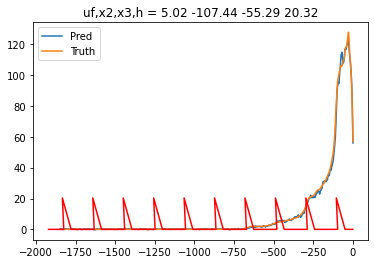

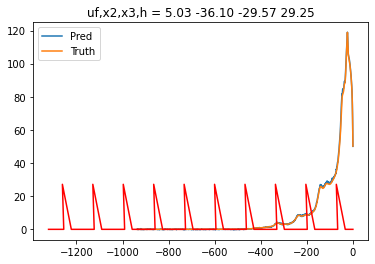

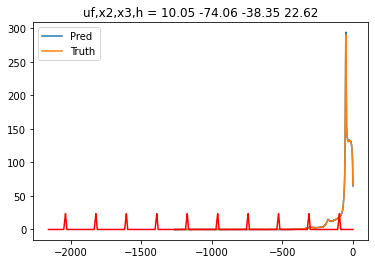

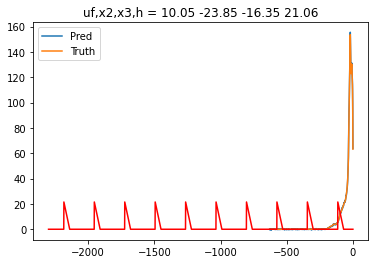

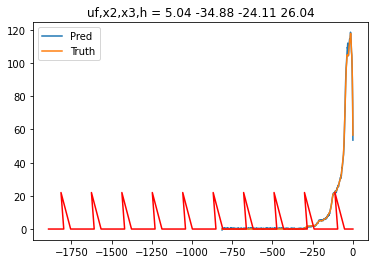

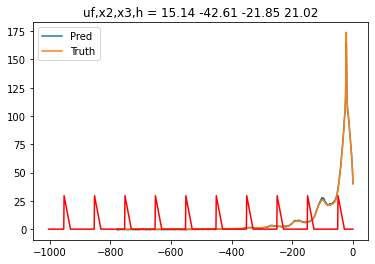

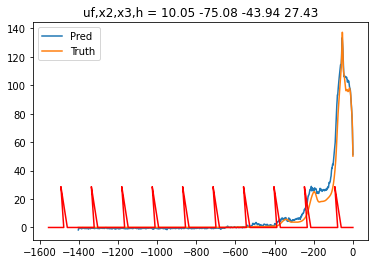

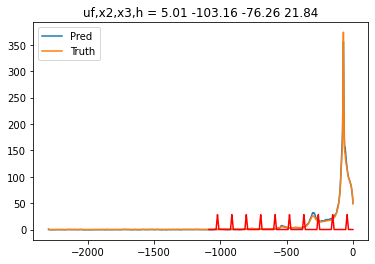

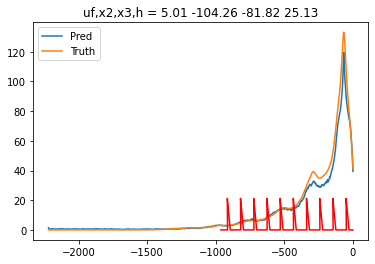

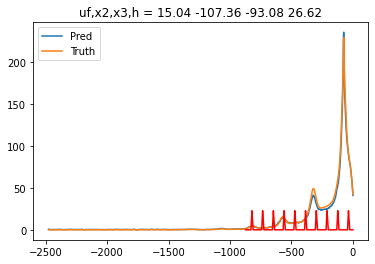

In [9]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50 
n_periods = 10
ncx = ncx1 + ncx2 + ncx3 + ncx4


PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_period_model_1d500", map_location=device)

print(count_params(model))


ntrain = 800
ntest = 200

batch_size = 20
learning_rate = 0.001
epochs = 501
step_size = 100
gamma = 0.5


modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)

for sample_id in range(0,10):
    sample_test_id = test_index[sample_id].item()
    sample, uf, L_p, x1, x2, x3, h = dataInfo[:, sample_test_id]
    mesh = x_test[sample_id, :, :]
    
    y_test_pred = model(x_test[sample_id:sample_id+1,:,:].to(device)).detach().cpu().numpy().flatten()
    print("rel. error is ", np.linalg.norm(y_test_pred - y_test[sample_id, :].numpy())/np.linalg.norm(y_test[sample_id, :]))
    xx = np.linspace(-L_p*n_periods, 0 ,n_periods*ncx+1)
    plt.figure()
    plt.plot(xx, y_test_pred, label="Pred")
    plt.plot(xx, y_test[sample_id, :], label="Truth")
    plt.plot(mesh[:, 0], mesh[:, 1], color="r")
    plt.title("uf,x2,x3,h = "+str(format(uf, '.2f'))+" "
                             +str(format(x2, '.2f'))+" "
                             +str(format(x3, '.2f'))+" "
                             +str(format(h, '.2f')))
    plt.legend()

# Length based data

82373057
inputX.shape (2001, 1000)
input shape: n_data, n_p, n_features =  torch.Size([1000, 2001, 2])
output shape: n_data, n_p, n_features =  torch.Size([1000, 2001])
rel. error is  0.0025912276
rel. error is  0.0024106707
rel. error is  0.06282508
rel. error is  0.0021530895
rel. error is  0.003931483
rel. error is  0.0024886625
rel. error is  0.002765719
rel. error is  0.0019067329
rel. error is  0.0025529822
rel. error is  0.003958415


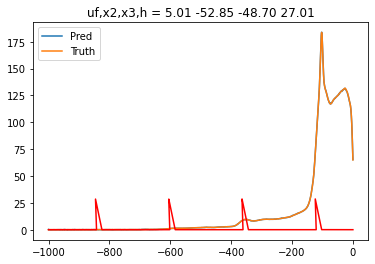

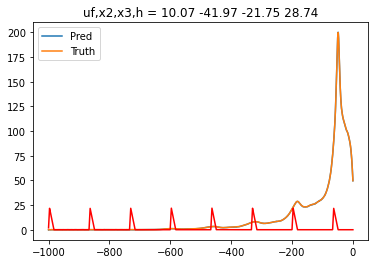

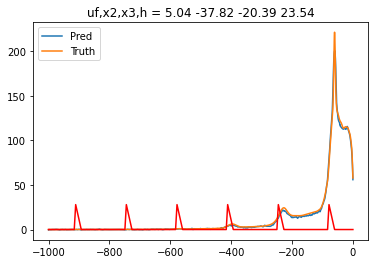

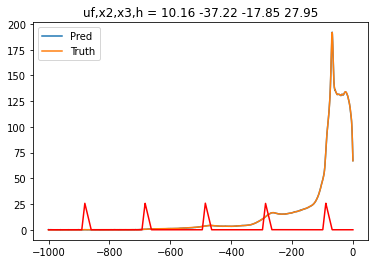

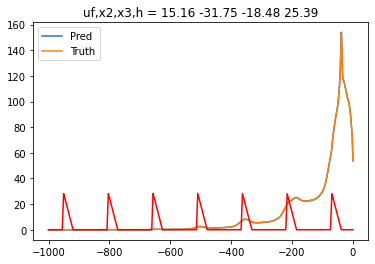

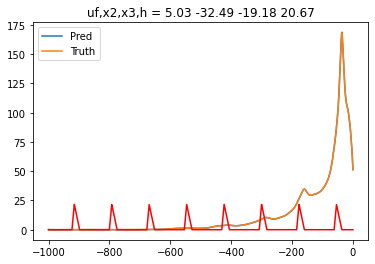

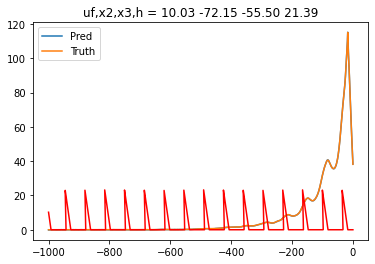

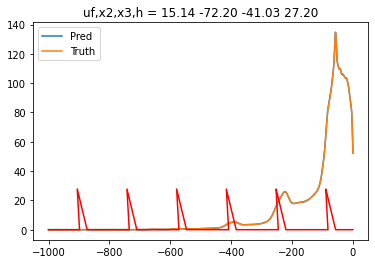

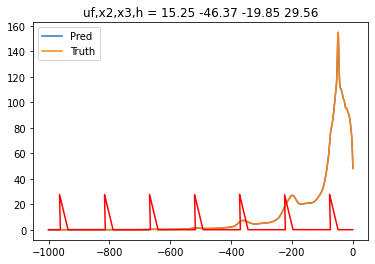

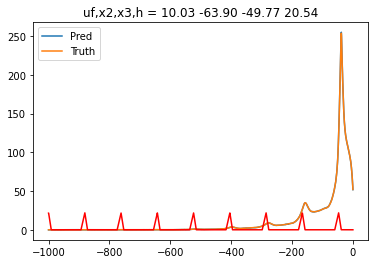

In [8]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
inputX_raw = np.load(INPUT_X)
inputY_raw = np.load(INPUT_Y)
inputPara_raw = np.load(INPUT_para)
output_raw = np.load(OUTPUT)

N_s, L_x = 2001, 1000


PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d500", map_location=device)

print(count_params(model))


ntrain = 800
ntest = 200

batch_size = 20
learning_rate = 0.001
epochs = 501
step_size = 100
gamma = 0.5


modes = n_periods*16
width = n_periods*32
# nx ny
s = n_periods*200 + 1

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




print("inputX.shape", inputX.shape)
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
print("input shape: n_data, n_p, n_features = ", input.shape)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
print("output shape: n_data, n_p, n_features = ", output.shape)

index = torch.randperm(ntrain+ntest)
train_index = index[:ntrain]
test_index = index[-ntest:]

x_train = input[train_index]
y_train = output[train_index]
x_test = input[test_index]
y_test = output[test_index]
x_train = x_train.reshape(ntrain, s, 2)
x_test = x_test.reshape(ntest, s, 2)


for sample_id in range(0,10):
    sample_test_id = test_index[sample_id].item()
    sample, uf, L_p, x1, x2, x3, h = dataInfo[:, sample_test_id]
    mesh = x_test[sample_id, :, :]
    
    y_test_pred = model(x_test[sample_id:sample_id+1,:,:].to(device)).detach().cpu().numpy().flatten()
    print("rel. error is ", np.linalg.norm(y_test_pred - y_test[sample_id, :].numpy())/np.linalg.norm(y_test[sample_id, :]))
    xx = np.linspace(-L_x, 0 ,N_s)
    plt.figure()
    plt.plot(xx, y_test_pred, label="Pred")
    plt.plot(xx, y_test[sample_id, :], label="Truth")
    plt.plot(mesh[:, 0], mesh[:, 1], color="r")
    plt.title("uf,x2,x3,h = "+str(format(uf, '.2f'))+" "
                             +str(format(x2, '.2f'))+" "
                             +str(format(x3, '.2f'))+" "
                             +str(format(h, '.2f')))
    plt.legend()